# 1. library Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

import time

In [2]:
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

from sklearn.decomposition import PCA, TruncatedSVD

In [3]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

## warnings occur at the resampling method: "SMOTEENN"
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
from sklearn.metrics import make_scorer, roc_curve, auc

# Import metrics functions from sklearn
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, \
                            precision_recall_curve, average_precision_score, confusion_matrix

# gonna use 5 models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

In [5]:
### Import H2O and initial an H2O instance.

# import h2o
# # help(h2o.init)
# h2o.init(nthreads=-1, min_mem_size=15, max_mem_size=20)

In [6]:
# h2o.cluster().shutdown()

# 2. Loading Data

Read the data generated in Rstudio by "data.table" from local.

In [7]:
df = pd.read_csv('loanStat2017Q1_model_2nd.csv')

In [8]:
print(df.head())
print(df.iloc[:, :15].info())

   loanStatus lastPymntFromIssueCat nextPymntFromIssueCat  \
0           0             (366,457]             (366,457]   
1           0             (366,457]             (366,457]   
2           0             (366,457]             (366,457]   
3           1             (275,366]             (275,366]   
4           0                (0,92]                (0,92]   

   mthsLastCreditPullSinceIssue mthsHardshipFromIssue mthsSettlementFromIssue  \
0                            14           no_hardship           no_settlement   
1                            14           no_hardship           no_settlement   
2                            13           no_hardship           no_settlement   
3                            12           no_hardship           no_settlement   
4                             1           no_hardship           no_settlement   

   mthsHardshipLength grade        term yrsEmpLengthCat    ...      \
0                   0     C   36 months              >9    ...       
1     

In [9]:
## extract names of all object columns 
catCols1 = df.select_dtypes(include='object').columns.tolist()

In [10]:
# Change numeric columns with no greater than 3 unique values to categorical 

df_nuniqueInt = df.select_dtypes(include='int').apply(lambda x: x.nunique())
num2cat = df_nuniqueInt[df_nuniqueInt <= 3].index.tolist()
num2cat.remove('loanStatus')

for col in num2cat:
    df[col] = df[col].astype('object')

In [11]:
numcols = [e for e in df.columns.tolist() if e not in (catCols1 + num2cat)]
print(numcols)

['loanStatus', 'mthsLastCreditPullSinceIssue', 'mthsHardshipLength', 'mthsFromEarliestCrLineToIssue', 'annualInclog10', 'dti', 'inqLast6mths', 'mortAcc', 'collections12MthsExMed', 'hsAmount', 'hsDpd', 'hsPayoffBalanceAmount', 'hsLastPaymentAmount', 'smAmount', 'smPercentage', 'smTerm', 'allUtil', 'origProjectedAdditionalAccruedInterest', 'loanAmntlog10', 'fundedAmntlog10', 'fundedAmntInvlog10', 'installmentlog10', 'outPrncplog10', 'outPrncpInvlog10', 'totalPymntlog10', 'totalPymntInvlog10', 'totRecPrncplog10', 'totalRecIntlog10', 'recoverieslog10', 'collectionRecoveryFeelog10', 'lastPymntAmntlog10', 'TotCurBallog10', 'TotalBalIllog10', 'maxBalBc', 'totalRevHiLimlog10', 'avgCurBallog10', 'totHiCredLimlog10', 'totalBcLimitlog10', 'delinq_2yrs', 'pub_rec', 'total_rec_late_fee', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev

In [12]:
df[numcols].filter(regex='_').describe()

,delinq_2yrs,pub_rec,total_rec_late_fee,open_acc_6m,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,inq_fi,total_cu_tl,...,num_actv_rev_tl,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens
count,96779.000000,96779.000000,9.677900e+04,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,...,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000,96779.000000
mean,0.349642,0.266318,8.878915e-01,0.917327,0.605317,1.521105,1.301026,2.764122,0.931803,1.460368,...,5.738022,7.508003,8.444911,8.300189,5.652838,0.089927,2.049804,93.581718,0.144577,0.081350
std,0.929675,0.716462,7.977796e+00,1.120670,0.830715,1.486059,1.499816,2.589798,1.435166,2.671873,...,3.447396,4.579339,7.358304,4.768307,3.319023,0.519021,1.825857,9.517363,0.396557,0.520256
min,0.000000,0.000000,-4.000000e-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.900000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,3.000000,4.000000,3.000000,5.000000,3.000000,0.000000,1.000000,90.500000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,...,5.000000,7.000000,6.000000,7.000000,5.000000,0.000000,2.000000,97.300000,0.000000,0.000000
75%,0.000000,0.000000,0.000000e+00,1.000000,1.000000,2.000000,2.000000,4.000000,1.000000,2.000000,...,7.000000,10.000000,11.000000,11.000000,7.000000,0.000000,3.000000,100.000000,0.000000,0.000000
max,21.000000,61.000000,4.366600e+02,14.000000,11.000000,22.000000,28.000000,54.000000,25.000000,68.000000,...,44.000000,64.000000,109.000000,69.000000,41.000000,19.000000,28.000000,100.000000,7.000000,61.000000


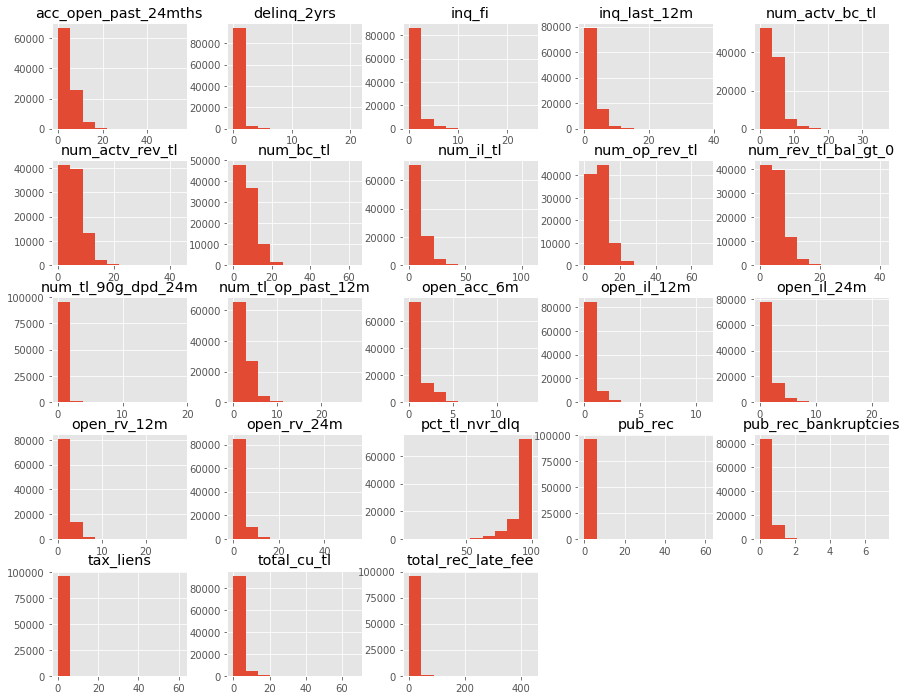

In [13]:
plt.rcParams['figure.figsize'] = [15, 12]
df[numcols].filter(regex='_').hist()
plt.show()

##### Since the data has been cleansed in R-studio. We just have to one-hot encode all categorical features.

In [14]:
catCols = catCols1 + num2cat
print(catCols)

['lastPymntFromIssueCat', 'nextPymntFromIssueCat', 'mthsHardshipFromIssue', 'mthsSettlementFromIssue', 'grade', 'term', 'yrsEmpLengthCat', 'home_ownership', 'addrStateCat', 'zipCodeCat', 'pymnt_plan', 'purpose', 'title', 'initial_list_status', 'debt_settlement_flag', 'settlementStatus', 'mthsSinceLastDelinq', 'mthsSinceLastRecord', 'mthsSinceRcntIl', 'mthsSinceRecentBc', 'mthsSinceRecentBcDlq', 'mthsSinceRecentInq', 'mthsSinceRecentRevolDelinq', 'moSinOldIlAcct', 'moSinOldRevTlOp', 'moSinRcntRevTlOp', 'moSinRcntTl', 'mthsSinceLastMajorDerog', 'ilUtilCat', 'bcOpenToBuyCat', 'bcUtilCat', 'numTl120dpd2mCat', 'percentBcGt75Cat', 'verificationStatus', 'hardshipFlag', 'disbursementMethod', 'deferralTermCat', 'hsLength']


In [15]:
df_dummies = pd.get_dummies(df, columns=catCols)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96779 entries, 0 to 96778
Columns: 229 entries, loanStatus to hsLength_3
dtypes: float64(30), int64(31), uint8(168)
memory usage: 60.5 MB


# 3. EDA
(See this in R script)

## Dimension reduction and Visualize the data

Note that the features in this dateset is mixed. So we have to the visualization based one-hot encoding on categorical features. 

In [16]:
y = df_dummies['loanStatus']
cols = [col for col in df_dummies.columns if col not in ['loanStatus']]
X = df_dummies[cols]

# verify and correctness of X and y
X.shape, y.shape

((96779, 228), (96779,))

In [17]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# # PCA Implementation
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
# t1 = time.time()
# print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', 
                             random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.7e+02 s
Truncated SVD took 0.65 s


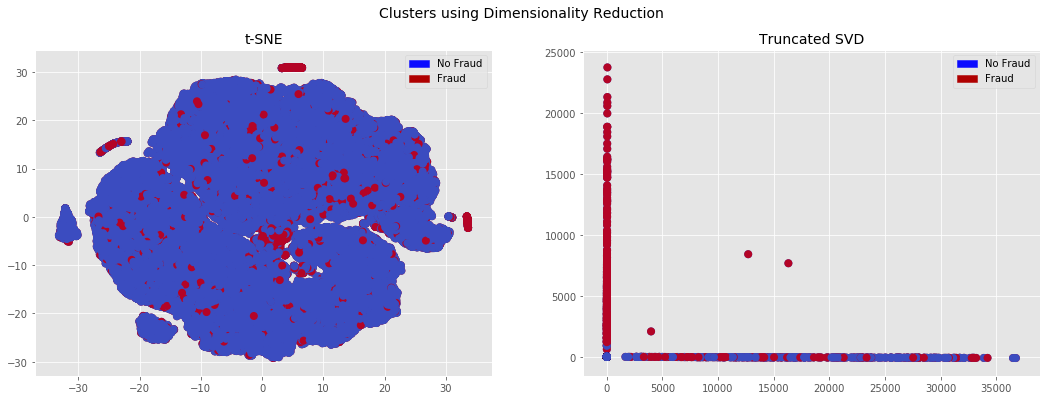

In [18]:
f, (ax1, ax3) = plt.subplots(1, 2, figsize=(18,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Good Loan', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Bad Loan', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Good Loan', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Bad Loan', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()